In [1]:
import warnings
warnings.filterwarnings('ignore')

import cv2
import numpy as np
import urllib.request
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.datasets import cifar10
# Instead of keras.preprocessing.image, import from tensorflow.keras.preprocessing.image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D
from keras.layers import Dropout, Flatten, BatchNormalization
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.models import load_model

In [2]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [3]:
# Then, let's split original training data to training and validation sets:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=0)

In [4]:
# checking dimensions of the training, validation and tests datasets
print('Train Images Shape:      ', X_train.shape)
print('Train Labels Shape:      ', y_train.shape)

print('\nValidation Images Shape: ', X_valid.shape)
print('Validation Labels Shape: ', y_valid.shape)

print('\nTest Images Shape:       ', X_test.shape)
print('Test Labels Shape:       ', y_test.shape)

Train Images Shape:       (45000, 32, 32, 3)
Train Labels Shape:       (45000, 1)

Validation Images Shape:  (5000, 32, 32, 3)
Validation Labels Shape:  (5000, 1)

Test Images Shape:        (10000, 32, 32, 3)
Test Labels Shape:        (10000, 1)


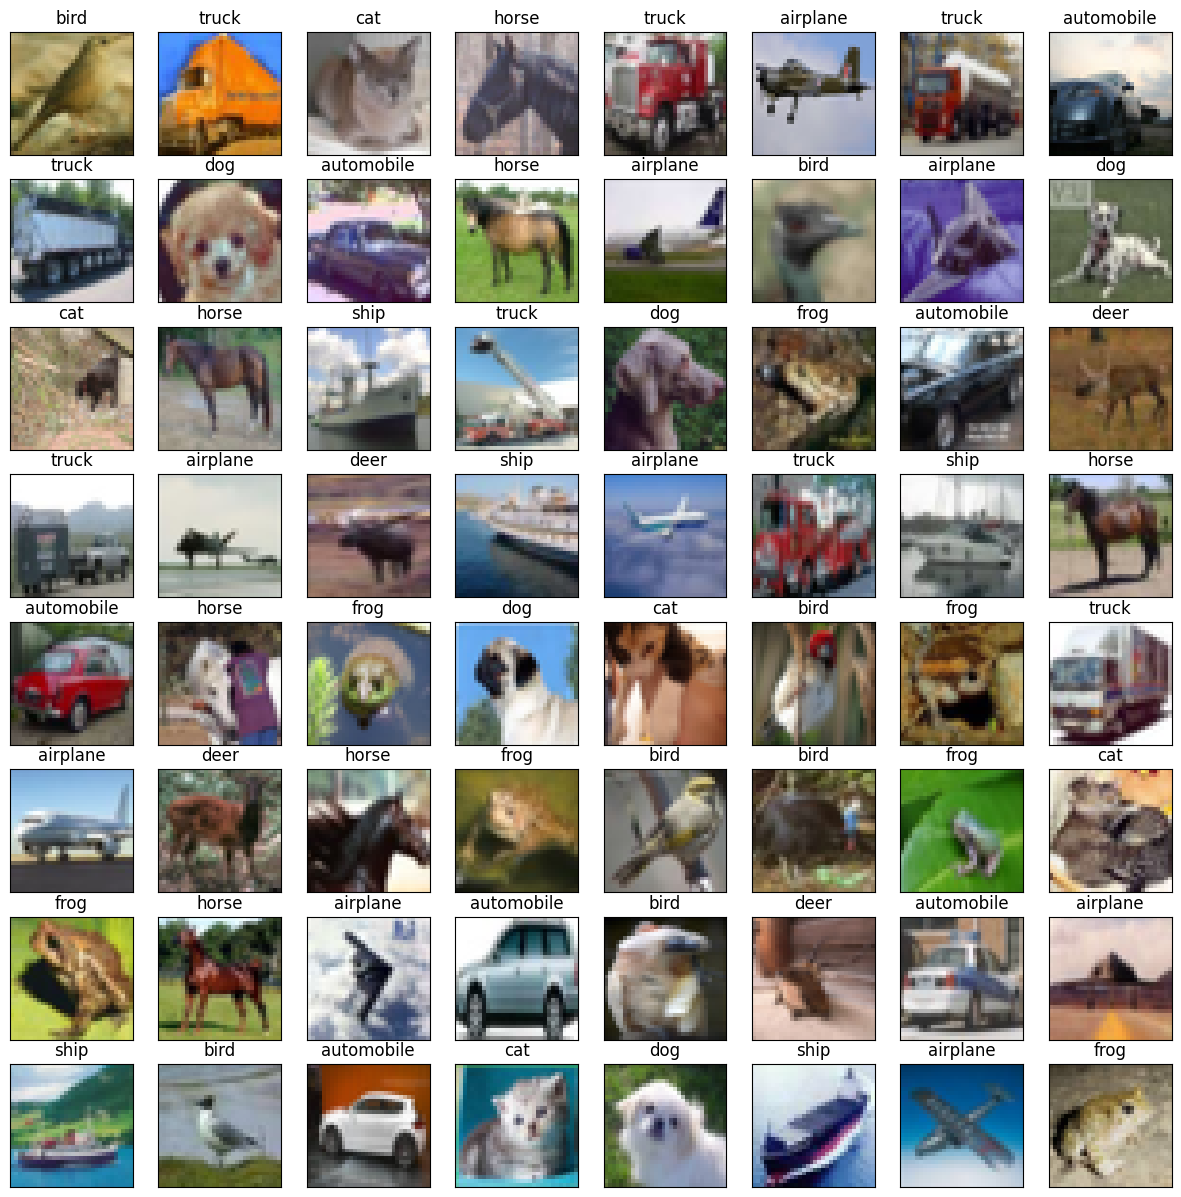

In [5]:
# CIFAR-10 classes
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Create a new figure
plt.figure(figsize=(15,15))

# Loop over the first 25 images
for i in range(64):
    # Create a subplot for each image
    plt.subplot(8, 8, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    # Display the image
    plt.imshow(X_train[i])

    # Set the label as the title
    plt.title(class_names[y_train[i][0]], fontsize=12)

# Display the figure
plt.show()

In [6]:
# preprocessing steps:

# Normalization of Image Data

# Convert pixel values data type to float32
X_train = X_train.astype('float32')
X_test  = X_test.astype('float32')
X_valid = X_valid.astype('float32')

# Calculate the mean and standard deviation of the training images
mean = np.mean(X_train)
std  = np.std(X_train)

# Normalize the data
# The tiny value 1e-7 is added to prevent division by zero
X_train = (X_train-mean)/(std+1e-7)
X_test  = (X_test-mean) /(std+1e-7)
X_valid = (X_valid-mean)/(std+1e-7)

In [7]:
# one hot encoding of the label sets

y_train = to_categorical(y_train, 10)
y_valid = to_categorical(y_valid, 10)
y_test  = to_categorical(y_test, 10)

In [8]:
# Data augmentation
data_generator = ImageDataGenerator(
    # Rotate images randomly by up to 15 degrees
    rotation_range=15,

    # Shift images horizontally by up to 12% of their width
    width_shift_range=0.12,

    # Shift images vertically by up to 12% of their height
    height_shift_range=0.12,

    # Randomly flip images horizontally
    horizontal_flip=True,

    # Zoom images in by up to 10%
    zoom_range=0.1,

    # Change brightness by up to 10%
    brightness_range=[0.9,1.1],

    # Shear intensity (shear angle in counter-clockwise direction in degrees)
    shear_range=10,

    # Channel shift intensity
    channel_shift_range=0.1,
)

In [9]:
# defining the CNN model architecture, will be using VGG16 networks

# Initialize a sequential model
model = Sequential()

# Set the weight decay value for L2 regularization
weight_decay = 0.0001

# Add the first convolutional layer with 32 filters of size 3x3
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay),
                 input_shape=X_train.shape[1:]))
# Add batch normalization layer
model.add(BatchNormalization())

# Add the second convolutional layer similar to the first
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)))
model.add(BatchNormalization())

# Add the first max pooling layer with pool size of 2x2
model.add(MaxPooling2D(pool_size=(2, 2)))
# Add dropout layer with 0.2 dropout rate
model.add(Dropout(rate=0.2))

# Add the third and fourth convolutional layers with 64 filters
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)))
model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)))
model.add(BatchNormalization())

# Add the second max pooling layer and increase dropout rate to 0.3
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.3))

# Add the fifth and sixth convolutional layers with 128 filters
model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)))
model.add(BatchNormalization())
model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)))
model.add(BatchNormalization())

# Add the third max pooling layer and increase dropout rate to 0.4
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.4))

# Add the seventh and eighth convolutional layers with 256 filters
model.add(Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)))
model.add(BatchNormalization())
model.add(Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)))
model.add(BatchNormalization())

# Add the fourth max pooling layer and increase dropout rate to 0.5
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.5))

# Flatten the tensor output from the previous layer
model.add(Flatten())

# Add a fully connected layer with softmax activation function for outputting class probabilities
model.add(Dense(10, activation='softmax'))

In [10]:
# this way we can see the architecture of the model
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 16, 16, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 8, 8, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 1,186,346 (4.53 MB)

 Trainable params: 1,184,426 (4.52 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [11]:
# Set the batch size for the training
batch_size = 64

# Set the maximum number of epochs for the training
epochs = 250

# Define the optimizer (Adam)
optimizer = Adam(learning_rate=0.0005)

# Compile the model with the defined optimizer, loss function, and metrics
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Add ReduceLROnPlateau callback
# Here, the learning rate will be reduced by half (factor=0.5) if no improvement in validation loss is observed for 10 epochs
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=0.00001)

# Add EarlyStopping callback
# Here, training will be stopped if no improvement in validation loss is observed for 40 epochs.
# The `restore_best_weights` parameter ensures that the model weights are reset to the values from the epoch
# with the best value of the monitored quantity (in this case, 'val_loss').
early_stopping = EarlyStopping(monitor='val_loss', patience=40, restore_best_weights=True, verbose=1)

# Fit the model on the training data, using the defined batch size and number of epochs
# The validation data is used to evaluate the model's performance during training
# The callbacks implemented are learning rate reduction when a plateau is reached in validation loss and
# stopping training early if no improvement is observed
model.fit(data_generator.flow(X_train, y_train, batch_size=batch_size),
          epochs=epochs,
          validation_data=(X_valid, y_valid),
          callbacks=[reduce_lr, early_stopping],
          verbose=2)

Epoch 1/250
704/704 - 74s - 105ms/step - accuracy: 0.3356 - loss: 2.3548 - val_accuracy: 0.4512 - val_loss: 1.6563 - learning_rate: 5.0000e-04
Epoch 2/250
704/704 - 46s - 65ms/step - accuracy: 0.4598 - loss: 1.7482 - val_accuracy: 0.5428 - val_loss: 1.4760 - learning_rate: 5.0000e-04
Epoch 3/250
704/704 - 44s - 63ms/step - accuracy: 0.5285 - loss: 1.5148 - val_accuracy: 0.5878 - val_loss: 1.3145 - learning_rate: 5.0000e-04
Epoch 4/250
704/704 - 45s - 64ms/step - accuracy: 0.5789 - loss: 1.3567 - val_accuracy: 0.6402 - val_loss: 1.1382 - learning_rate: 5.0000e-04
Epoch 5/250
704/704 - 46s - 65ms/step - accuracy: 0.6094 - loss: 1.2457 - val_accuracy: 0.6304 - val_loss: 1.2137 - learning_rate: 5.0000e-04
Epoch 6/250
704/704 - 45s - 64ms/step - accuracy: 0.6418 - loss: 1.1432 - val_accuracy: 0.6652 - val_loss: 1.1146 - learning_rate: 5.0000e-04
Epoch 7/250
704/704 - 45s - 63ms/step - accuracy: 0.6644 - loss: 1.0786 - val_accuracy: 0.7018 - val_loss: 0.9999 - learning_rate: 5.0000e-04
Epoch

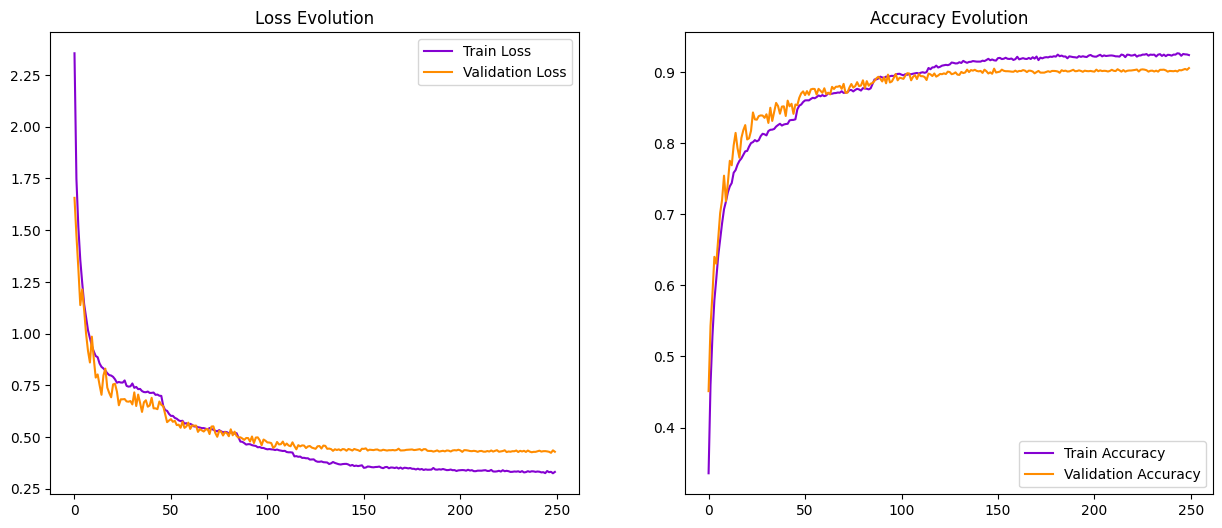

In [12]:
plt.figure(figsize=(15,6))

# Plotting the training and validation loss
plt.subplot(1, 2, 1)
plt.plot(model.history.history['loss'], label='Train Loss', color='#8502d1')
plt.plot(model.history.history['val_loss'], label='Validation Loss', color='darkorange')
plt.legend()
plt.title('Loss Evolution')

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(model.history.history['accuracy'], label='Train Accuracy', color='#8502d1')
plt.plot(model.history.history['val_accuracy'], label='Validation Accuracy', color='darkorange')
plt.legend()
plt.title('Accuracy Evolution')

plt.show()

In [13]:
# Use the model to make predictions, evaluate on test data
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)

print('\nTest Accuracy:', test_acc)
print('Test Loss:    ', test_loss)

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9018 - loss: 0.4435

Test Accuracy: 0.9016000032424927
Test Loss:     0.43795323371887207


In [47]:
# Fetch the raw image from GitHub
url = "https://images.dog.ceo/breeds/buhund-norwegian/hakon3.jpg"
resp = urllib.request.urlopen(url)
image = np.asarray(bytearray(resp.read()), dtype="uint8")
image = cv2.imdecode(image, cv2.IMREAD_UNCHANGED)

# Convert the image from BGR to RGB
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

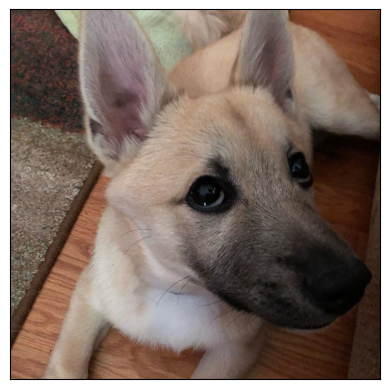

In [48]:
# Display the image
plt.imshow(image)
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.show()

In [49]:
# Resize it to 32x32 pixels
image = cv2.resize(image, (32,32))

# Normalize the image
image = (image-mean)/(std+1e-7)

# Add an extra dimension because the model expects a batch of images
image = image.reshape((1, 32, 32, 3))

In [50]:
prediction = model.predict(image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


In [44]:
predicted_class = prediction.argmax()

print('Predicted class: ', class_names[predicted_class])

Predicted class:  frog


In [ ]:
b